## Step1. Setup

In [2]:
from platform import python_version
print(python_version())

3.8.0


In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [4]:
### install keras-tuner
## python3 -m pip install --user keras-tuner 
import kerastuner as kt

## Step 2. Download and prepare the dataset 

we will use the Fashion MNIST dataset, ie. images of clothing. 

In [64]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [65]:
## lets check the number of train/test images
print('No of train images: ', img_train.shape)
print('No of test images: ', img_test.shape)
print('label format for trainig:', label_train.shape)
print('label format for testing:', label_test.shape)

No of train images:  (60000, 28, 28)
No of test images:  (10000, 28, 28)
label format for trainig: (60000,)
label format for testing: (10000,)


Label of indx 2201 :  2


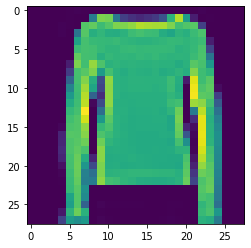

In [66]:
## Lets visualize the dataset
import matplotlib.pyplot as plt

indx=2201
plt.imshow(img_train[indx])
print('Label of indx',indx,': ',label_train[indx])

In [67]:
## Normalize the dataset
img_train = img_train.astype('float32')/255.0
img_test = img_test.astype('float32')/255.0

## Step 3. Define the model

while building a model for hypertuning, one should define the hyperparamet search spave in addition to the model architecture.
The model setup for hypertuning is called a hypermodel. It could be defined through two approaches:
    
    * By using a model builder function
    * By subclassing the HyperModel class of the Keras Tuner API

In [68]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

### Instentiate the tuner and perform hypertuning

1. keras tuner has four tuners: RandomSearch, Hyperband, BayesianOptimization and Sklearn
2. To instentiate the Hyperband tuner, one must specify the hypermodel, the 'pobjective' to optimize and the  maximum number of epoches to train 'max_epochs'

In [69]:
## ?kt.Hyperband

In [70]:
tuner = kt.Hyperband(model_builder, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                    directory='my_dir',
                    project_name='intro_to_tuning')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_tuning/oracle.json


In [71]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [72]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hps.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hps.get('learning_rate')}""")

Trial 30 Complete [00h 00m 36s]
val_accuracy: 0.8549166917800903

Best val_accuracy So Far: 0.890666663646698
Total elapsed time: 00h 05m 52s
INFO:tensorflow:Oracle triggered exit

The Optimal number of units in the first dense layeer is 224 and 
the optimal learning rate for the optimal learning_rate is 0.001


## Step 4. Train the Model

Find the optimal number of epoches to train the model with the hyperparameter obrained from the search.



In [73]:
# Build the model with the optimal hyperparamers and train it on the data for 50 epochs
model=tuner.hypermodel.build(best_hps)
history=model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) +1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6350 - accuracy: 0.7783 - val_loss: 0.4226 - val_accuracy: 0.8429
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3845 - accuracy: 0.8587 - val_loss: 0.3594 - val_accuracy: 0.8686
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3386 - accuracy: 0.8768 - val_loss: 0.3565 - val_accuracy: 0.8738
Epoch 4/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3096 - accuracy: 0.8856 - val_loss: 0.3318 - val_accuracy: 0.8805
Epoch 5/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2963 - accuracy: 0.8911 - val_loss: 0.3365 - val_accuracy: 0.8796
Epoch 6/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2762 - accuracy: 0.8972 - val_loss: 0.3232 - val_accuracy: 0.8860
Epoch 7/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.2609 - accuracy: 0.9025 - val_loss: 0.3162 - val_accuracy:

In [74]:
## to plot error/accuracy side by side
fig = plt.figure()
fig.patch.set_facecolor('white')

def plot_2(history=history_vgg,
          ylim_low=0.4, ylim_high=1.0, 
          label_list=[]    ,       
          leg_loc='lower left'):
    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label=label_list[0], c='green', ls='-')
    plt.plot(history.history['val_accuracy'],label=label_list[1], c='green',ls='--')

    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(loc=leg_loc)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label=label_list[0], c='red', ls='-')
    plt.plot(history.history['val_loss'],label=label_list[1],  c='red',ls='--')

    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(loc=leg_loc)
    plt.ylim(ylim_low,ylim_high)

<Figure size 432x288 with 0 Axes>

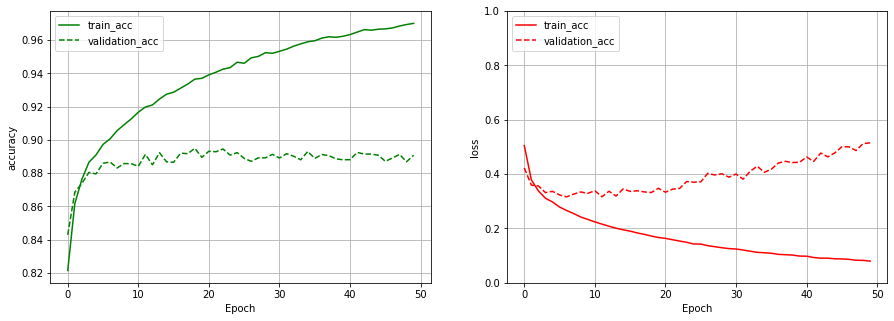

In [75]:
plot_2(history=history, label_list=['train_acc', 'validation_acc'], ylim_low=0, leg_loc='upper left')

In [76]:
## Reinstiate the hypermodel and train it with optimal nunber of epoches

hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6421 - accuracy: 0.7773 - val_loss: 0.4118 - val_accuracy: 0.8525
Epoch 2/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3909 - accuracy: 0.8588 - val_loss: 0.3797 - val_accuracy: 0.8636
Epoch 3/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3370 - accuracy: 0.8777 - val_loss: 0.3385 - val_accuracy: 0.8767
Epoch 4/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3085 - accuracy: 0.8854 - val_loss: 0.3364 - val_accuracy: 0.8744
Epoch 5/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2850 - accuracy: 0.8941 - val_loss: 0.3338 - val_accuracy: 0.8802
Epoch 6/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2674 - accuracy: 0.9012 - val_loss: 0.3252 - val_accuracy: 0.8852
Epoch 7/19
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2669 - accuracy: 0.8991 - val_loss: 0.3434 - val_accuracy:

## Step 5. Evaluate on test data

In [65]:
## Evaluate the hyoermodel on the test data
eval_result =hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3791 - accuracy: 0.8840
[test loss, test accuracy]: [0.3790961802005768, 0.8840000033378601]


## Step 6. Lets change the Model Infrastructure to VGG 

In [23]:
img_train.shape

(60000, 28, 28)

In [85]:
img_train = img_train.reshape(list(img_train.shape) + [1])
img_test = img_test.reshape(list(img_test.shape) + [1])

img_train.shape

(60000, 28, 28, 1)

In [35]:
# Normalize pixel values to be between 0 and 1
from tensorflow.keras.utils import to_categorical
import numpy as np
label_train = to_categorical(label_train, len(np.unique(label_train)))
label_test = to_categorical(label_test, len(np.unique(label_test)))

In [30]:
def model_builder_vgg(hp):
    model= keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',input_shape=(28,28,1)))
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2, 2))
        
    # The second convolution
    model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2,2))
        
    # The third convolution
    model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2,2))
   
    model.add(keras.layers.Flatten())
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [31]:
tuner_vgg = kt.Hyperband(model_builder_vgg, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                        )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
____________________________________

In [32]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [36]:
tuner_vgg.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hp_vgg=tuner_vgg.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hp_vgg.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hp_vgg.get('learning_rate')}""")

Trial 31 Complete [00h 18m 20s]
val_accuracy: 0.9154999852180481

Best val_accuracy So Far: 0.9243333339691162
Total elapsed time: 03h 51m 22s
INFO:tensorflow:Oracle triggered exit

The Optimal number of units in the first dense layeer is 480 and 
the optimal learning rate for the optimal learning_rate is 0.001


In [39]:
# Build the model with the optimal hyperparamers and train it on the data for 50 epochs
model_vgg=tuner_vgg.hypermodel.build(best_hp_vgg)
history_vgg=model_vgg.fit(img_train, label_train, epochs=50, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

1500/1500 [==============================] - 99s 66ms/step - loss: 0.0421 - accuracy: 0.9886 - val_loss: 0.6821 - val_accuracy: 0.9178
Epoch 44/50
1500/1500 [==============================] - 99s 66ms/step - loss: 0.0405 - accuracy: 0.9884 - val_loss: 0.5990 - val_accuracy: 0.9197
Epoch 45/50
1500/1500 [==============================] - 100s 66ms/step - loss: 0.0265 - accuracy: 0.9918 - val_loss: 0.7187 - val_accuracy: 0.9196
Epoch 46/50
1500/1500 [==============================] - 100s 67ms/step - loss: 0.0435 - accuracy: 0.9879 - val_loss: 0.6818 - val_accuracy: 0.9189
Epoch 47/50
1500/1500 [==============================] - 100s 67ms/step - loss: 0.0487 - accuracy: 0.9870 - val_loss: 0.7068 - val_accuracy: 0.9195
Epoch 48/50
1500/1500 [==============================] - 101s 67ms/step - loss: 0.0279 - accuracy: 0.9919 - val_loss: 0.7273 - val_accuracy: 0.9158
Epoch 49/50
1500/1500 [==============================] - 101s 67ms/step - loss: 0.0462 - accuracy: 0.9871 - val_loss: 0.6173 -

NameError: name 'val_acc_per_epoch' is not defined

In [43]:
val_acc_per_epoch_vgg = history_vgg.history['val_accuracy']
best_epoch_vgg = val_acc_per_epoch_vgg.index(max(val_acc_per_epoch_vgg)) +1
print('Best epoch: %d' % (best_epoch_vgg,))

Best epoch: 11


In [45]:
## Reinstiate the hypermodel and train it with optimal number of epoches
hypermodel_vgg = tuner_vgg.hypermodel.build(best_hp_vgg)
hypermodel_vgg.fit(img_train, label_train, epochs=best_epoch_vgg, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

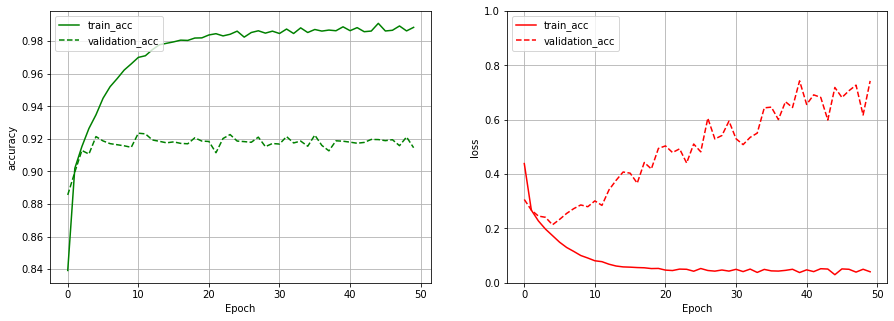

In [49]:
plot_2(history=history_vgg, label_list=['train_acc', 'validation_acc'], ylim_low=0, leg_loc='upper left')

In [54]:
## Evaluate the hyoermodel on the test data
eval_result_vgg =hypermodel_vgg.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result_vgg)

313/313 [==============================] - 4s 12ms/step - loss: 0.3187 - accuracy: 0.9196
[test loss, test accuracy]: [0.31867173314094543, 0.9196000099182129]


In [57]:
## to plot Two plots with different History

fig = plt.figure()
fig.patch.set_facecolor('white')

def plot_2_model(history1=history_vgg, history2=history_vgg,
          ylim_low=0.4, ylim_high=1.0, 
          label_list=[]    ,       
          leg_loc='lower left'):
    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history1.history['accuracy'], label=label_list[0], c='orange', ls='-')
    plt.plot(history1.history['val_accuracy'], c='orange',ls='--')

    plt.plot(history2.history['accuracy'], label=label_list[1], c='blue', ls='-')
    plt.plot(history2.history['val_accuracy'], c='blue', ls='--')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(loc=leg_loc)

    plt.subplot(1,2,2)
    plt.plot(history1.history['loss'], label=label_list[0], c='orange', ls='-')
    plt.plot(history1.history['val_loss'],  c='orange',ls='--')

    plt.plot(history2.history['loss'], label=label_list[1], c='blue', ls='-')
    plt.plot(history2.history['val_loss'],  c='blue', ls='--')

    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(loc=leg_loc)
    plt.ylim(ylim_low,ylim_high)

<Figure size 432x288 with 0 Axes>

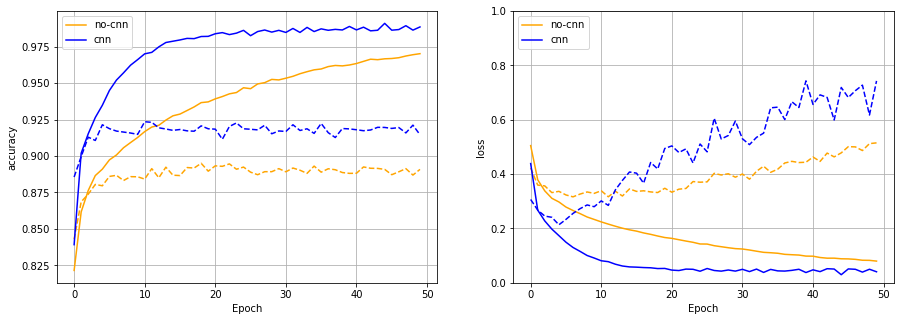

In [79]:
plot_2_model(history1=history, history2=history_vgg,label_list=['no-cnn', 'cnn'], ylim_low=0, leg_loc='upper left')

In [81]:
def model_builder_vgg_L1reg(hp):
    model= keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same',input_shape=(28,28,1)))
    model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2, 2))
        
    # The second convolution
    model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2,2))
        
    # The third convolution
    model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(2,2))
   
    model.add(keras.layers.Flatten())
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(l1=0.001)))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [83]:
tuner_vgg_L1reg = kt.Hyperband(model_builder_vgg_L1reg, 
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3, # Int. Reduction factor for the number of epochs/number of models for each bracket.
                        )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [86]:
tuner_vgg_L1reg.search(img_train, label_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

## get the optimal hyperparameters
best_hp_vgg_L1reg=tuner_vgg_L1ref.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The Optimal number of units in the first dense layeer is {best_hp_vgg_L1reg.get('units')} and 
the optimal learning rate for the optimal learning_rate is {best_hp_vgg_L1reg.get('learning_rate')}""")


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units             |32                |?                 
learning_rate     |0.0001            |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)        

ValueError: in user code:

    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/pooja/.local/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 1) and (32, 10) are incompatible


In [87]:
img_train.shape

(60000, 28, 28, 1)

## Referenz.

[kerastuner_on_RandomForest](https://github.com/keras-team/keras-tuner)